In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train = pd.read_csv("model.csv")
train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,...,29.85,29.85,0,0,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,53.85,108.15,1,0,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


# 1. Determine X and Y variables

In [3]:
X = train.drop(["customerID", "Churn"], axis = 1)
y = train["Churn"]

# 2. Splitting Training and Testing data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)

# 3. Modeling

### Logistic Regression

In [5]:
def evaluate(model, X_test, y_test):
    prediction_test = model.predict(X_test)
    results = pd.DataFrame({"Accuracy":[metrics.accuracy_score(y_test, prediction_test)],
                            "Error Rate":[1-metrics.accuracy_score(y_test, prediction_test)],
                           "Precision":[metrics.precision_score(y_test, prediction_test)],
                           "Recall":[metrics.recall_score(y_test, prediction_test)]})
    return results

In [6]:
def calculate_roc_auc(model,X_test, y_test):
    prediction_test = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction_test)
    score = pd.DataFrame({"ROC-AUC":[metrics.auc(fpr, tpr)]})
    plot_roc_auc(fpr, tpr)
    return score

In [7]:
def plot_roc_auc(fpr, tpr):
    f, ax = plt.subplots(figsize=(14,8))
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label="AUC = %0.2f" %(roc_auc))
    plt.plot([0,1],[0,1], linestyle = "--", lw=3, color="r", label= "Random", alpha=.8)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()

In [8]:
def plot_confusion_matrix(data, labels):
    sns.set(color_codes = True)
    plt.figure(1, figsize=(9,6))
    plt.title("Confusion Matrix")
    sns.set(font_scale = 1.4)
#     fmt='g' not showing scientific notation for number labeling
    ax = sns.heatmap(data, annot=True, fmt='g',cmap="YlGnBu", cbar_kws = {"label":"Scale"})
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set(ylabel="Actual cases", xlabel="Predicted cases")
    plt.show()

In [9]:
log = LogisticRegression()
log.fit(X_train, y_train)
evaluate(log, X_test, y_test)

,Accuracy,Error Rate,Precision,Recall
0,0.810903,0.189097,0.691099,0.551148


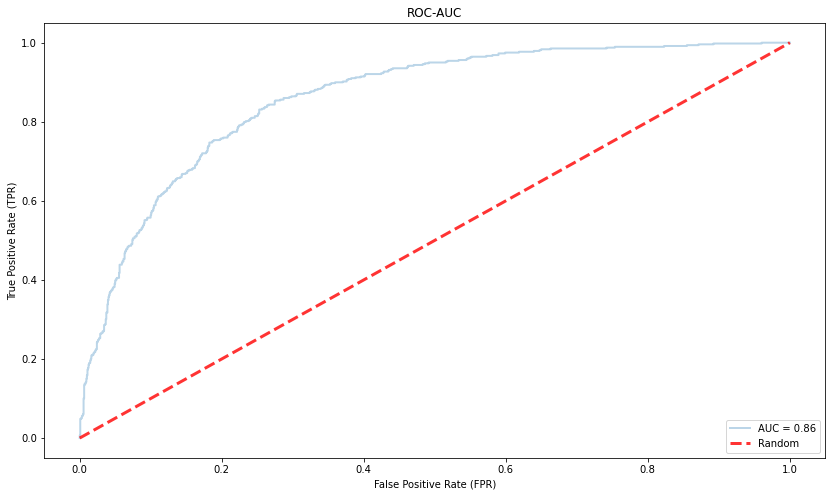

,ROC-AUC
0,0.860128


In [10]:
calculate_roc_auc(log, X_test, y_test)

<AxesSubplot:>

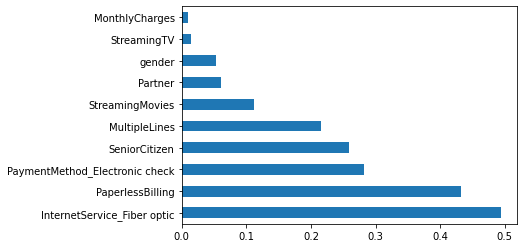

In [11]:
importance = log.coef_[0]
weights = pd.Series(importance, index = X.columns.values)
weights.sort_values(ascending=False)[:10].plot(kind="barh")

In [12]:
weights.sort_values(ascending=True).head(10)

Contract_Two year                       -0.626847
PhoneService                            -0.572959
OnlineSecurity                          -0.567817
TechSupport                             -0.518758
InternetService_No                      -0.504360
Contract_One year                       -0.359001
OnlineBackup                            -0.245521
PaymentMethod_Mailed check              -0.213811
PaymentMethod_Credit card (automatic)   -0.191315
Dependents                              -0.181980
dtype: float64

### Observations from Logistic Regression:
We can see some variables have positive relation to Churn rate, and some have negative relation (means the likelihood of churn decreases with these variables):
1. 2-year contract related to higher tenure from our previous observation, and this model shoes that having a 2-year contract reduces chances of churn. (the most negative relation with churn in this model)
2. It is interesting that Fiber optic (much faster services) for internet service relate to higher churn rate. We should explore more for better understanding

### XGB 

C:\Users\ACI\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


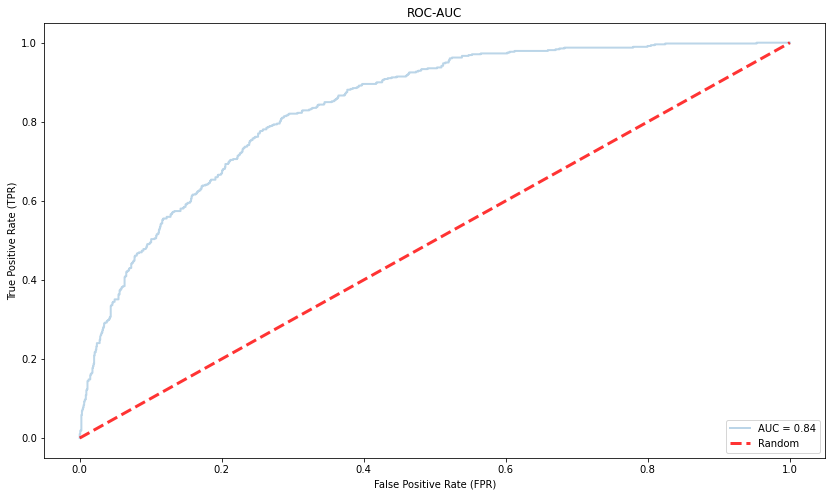

,ROC-AUC
0,0.837202


In [13]:
xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=500, n_jobs=-1)
xgb.fit(X_train, y_train)
calculate_roc_auc(xgb, X_test, y_test)

In [14]:
evaluate(xgb, X_test, y_test)

,Accuracy,Error Rate,Precision,Recall
0,0.788756,0.211244,0.642667,0.503132


In [15]:
clf=RandomForestClassifier(n_jobs=4,n_estimators=500,max_depth=6)
clf.fit(X,y)

RandomForestClassifier(max_depth=6, n_estimators=500, n_jobs=4)

In [16]:
fscores = pd.DataFrame({'feature':X.columns,'importance':clf.feature_importances_}).sort_values(by='importance',ascending=True)
fscores.tail()

,feature,importance
21,PaymentMethod_Electronic check,0.097250
19,Contract_Two year,0.103235
16,InternetService_Fiber optic,0.137504
15,TotalCharges,0.137597
4,tenure,0.196383


<BarContainer object of 23 artists>

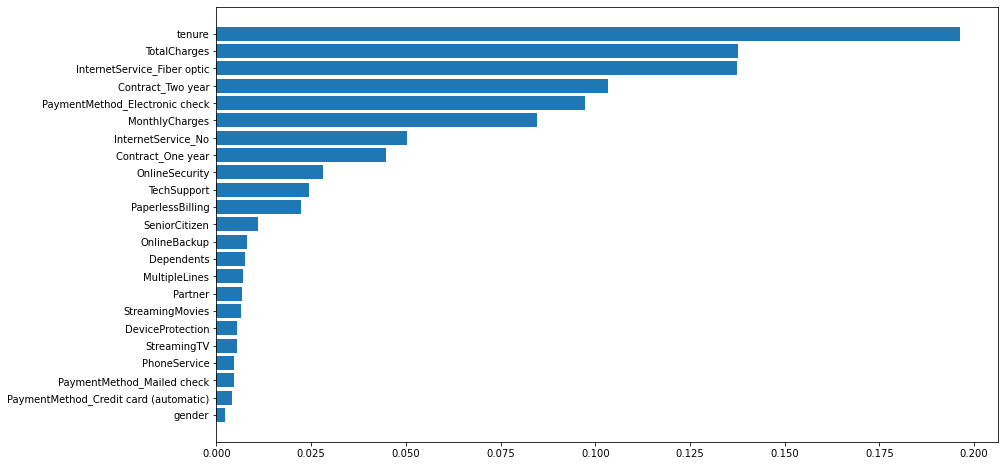

In [17]:
f, ax = plt.subplots(figsize=(14,8))
plt.barh(fscores.feature,fscores.importance)

In [18]:
import shap
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

NameError: name 'rfc' is not defined

### Random Forest Classification 

In [19]:
clf=RandomForestClassifier(n_jobs = -1,random_state = 42)
clf.fit(X_train,y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

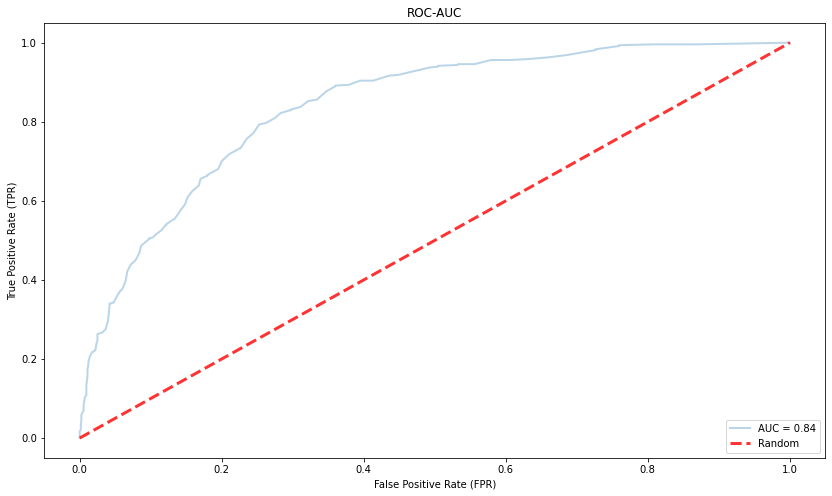

,ROC-AUC
0,0.839213


In [20]:
calculate_roc_auc(clf, X_test, y_test)

In [21]:
evaluate(clf, X_test, y_test)

,Accuracy,Error Rate,Precision,Recall
0,0.794435,0.205565,0.675676,0.469729


<AxesSubplot:>

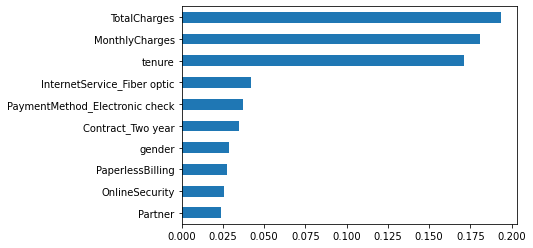

In [22]:
# no negative values
importances = clf.feature_importances_
weights = pd.Series(importances, index = X.columns.values)
weights.sort_values()[-10:].plot(kind="barh")

### Observations from Random Forest Classification:
- From this model, Total Charges, montly charges, Tenure are the most important predictor variables for Churn Rate

### Optimizing Hyperparameters in Random Forest Classification
- Hyperparameter is a parameter of the model that is set prior to the start of the learning process. 
- For Random Forest Classifier, There are multiple hyperparameters that can be adjusted:
    1. n_estimators: the number of trees in the forest of the model; e.g., 10 means that 10 different decision trees will be constructed
    2. max_depth: the maximum depth of each tree. Default value is None, which means that each tree will expand untile every leaf is pure (the leaf only has the same class of data)
    3. min_samples_split: minimum number of samples required to split an internal leaf node. Default is 2, it means an internal node must have at least 2 samples before it can be split to have more specific classification.
    4. min_samples_leaf: the minimum number of samples required to be at a leaf node. Default value is 1, which means that every leaf must have at least 1 sample that it classifier. 

In [23]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [5, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [10, 50, None], 'max_features': [5, 10],
                          'n_estimators': [5, 25]}],
             scoring='accuracy')

In [24]:
grid_search_forest.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=10, max_features=5,
                       n_estimators=25, n_jobs=-1, random_state=42)

In [25]:
grid_best= grid_search_forest.best_estimator_.fit(X_train,y_train)
evaluate(grid_best, X_test, y_test)

,Accuracy,Error Rate,Precision,Recall
0,0.796139,0.203861,0.675439,0.482255


=== Confusion Matrix ===
[[1171  111]
 [ 248  231]]




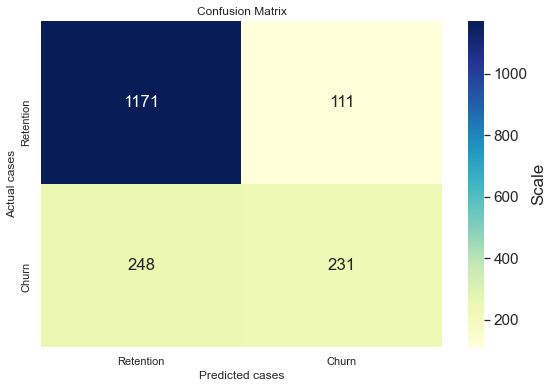

In [26]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, grid_search_forest.best_estimator_.predict(X_test)))
print('\n')
plot_confusion_matrix(confusion_matrix(y_test,grid_search_forest.best_estimator_.predict(X_test)), ["Retention","Churn"])

In [27]:
print("=== Classification Report ===")
print(classification_report(y_test, grid_search_forest.best_estimator_.predict(X_test)))
print('\n')

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1282
           1       0.68      0.48      0.56       479

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.71      1761
weighted avg       0.78      0.80      0.78      1761





<AxesSubplot:>

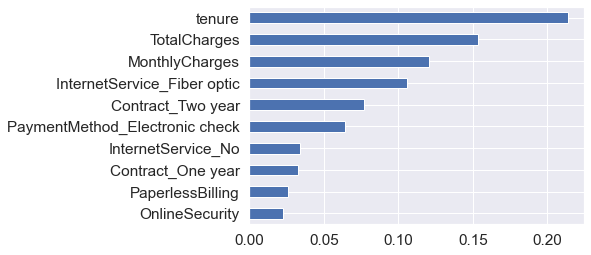

In [28]:
importances = grid_search_forest.best_estimator_.feature_importances_
weights = pd.Series(importances, index = X.columns.values)
weights.sort_values()[-10:].plot(kind="barh")

### Observations from Random Forest Classification:
From this model, Tenure, Total Charges, montly charges  are the most important predictor variables for Churn Rate, which is pretty similar to previous Random Forest Classification model
- This model has improved.

In [32]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


{'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 300}


In [33]:
rfc = RandomForestClassifier(n_estimators=2000, max_depth=300, max_features='auto')
rfc.fit(X_train,y_train)
# rfc_predict = rfc.predict(X_test)
evaluate(rfc, X_test, y_test)

,Accuracy,Error Rate,Precision,Recall
0,0.794435,0.205565,0.673591,0.473904


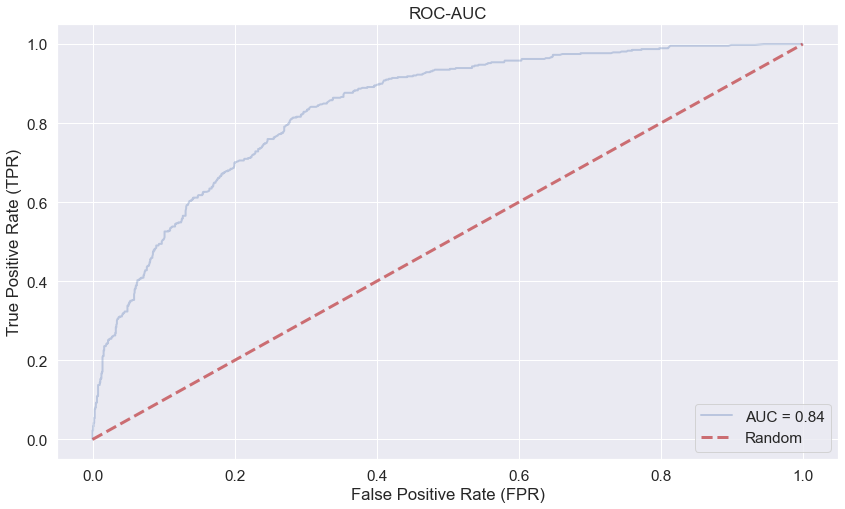

,ROC-AUC
0,0.837929


In [34]:
calculate_roc_auc(rfc, X_test, y_test)

=== Confusion Matrix ===
[[1172  110]
 [ 252  227]]




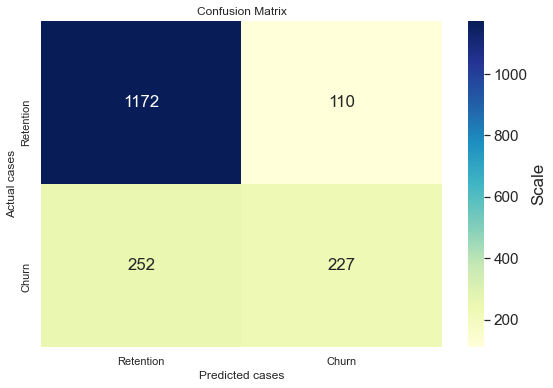

In [35]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc.predict(X_test)))
print('\n')
plot_confusion_matrix(confusion_matrix(y_test, rfc.predict(X_test)), ["Retention","Churn"])

In [36]:
print("=== Classification Report ===")
print(classification_report(y_test,rfc.predict(X_test)))
print('\n')

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1282
           1       0.67      0.47      0.56       479

    accuracy                           0.79      1761
   macro avg       0.75      0.69      0.71      1761
weighted avg       0.78      0.79      0.78      1761





<AxesSubplot:>

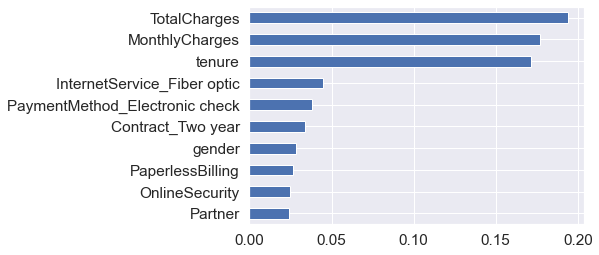

In [37]:
importances = rfc.feature_importances_
weights = pd.Series(importances, index = X.columns.values)
weights.sort_values()[-10:].plot(kind="barh")

### Observations from Random Forest Classification:
From this model, Total Charges, montly charges, Tenure are the most important predictor variables for Churn Rate, which is similar as previous 2 models